# Do you need psuedo labels?

# You might need a token for space itself? start and stop tokens?

# Sentiment Classification model with test as well in train? Will increase the vocab size as well?

# * https://www.tensorflow.org/tutorials/text/transformer
# * https://pytorch.org/tutorials/beginner/transformer_tutorial.html

## Settings

In [1]:
# CONTROLS
MODEL_PREFIX = "V12"
MODEL_NUMBER = MODEL_PREFIX[-2:]
TRAIN_SPLIT_RATIO = 0.8

DROPOUT = 0.3
MIN_LR = 1e-6
MAX_LR = 1e-3
BATCH_SIZE = 1024
PREDICT_BATCH_SIZE = 2048
STEP_SIZE = 10
CLR_METHOD = "triangular" # exp_range, triangular, triangular2
NUM_EPOCHS = 200

## Libraries

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

#from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight

import pickle, os, sys, re

import spacy
from spacy.lang.en import English

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv1D, Conv2D, LSTM, Embedding, Dense, concatenate, MaxPooling2D, Softmax, Flatten
from tensorflow.keras.layers import BatchNormalization, Dropout, Reshape, Activation, Bidirectional, TimeDistributed
from tensorflow.keras.layers import RepeatVector, Multiply, MaxPooling1D
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer

def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

%matplotlib inline

In [3]:
from tensorflow.keras.callbacks import *
import tensorflow.keras.backend as K

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [4]:
pd.set_option('display.max_colwidth', -1)
np.random.seed(54321)

c:\users\deepak\miniconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


## Import Data

In [5]:
df = pd.read_csv("../data/train.csv",
                 dtype={"time":np.float64,"signal":np.float64,"open_channels":np.int16},
                 encoding="utf8")

print(pd.concat((df.dtypes, df.isna().sum()), axis=1))
print(df.shape)

# Counts of various columns
print({i:df[i].nunique() for i in df.columns})
print(df.describe()) #.astype(int)
df.head(2)

                    0  1
textID         object  0
text           object  1
selected_text  object  1
sentiment      object  0
(27481, 4)
{'textID': 27481, 'text': 27480, 'selected_text': 22463, 'sentiment': 3}
            textID                                     text selected_text  \
count   27481       27480                                    27480          
unique  27481       27480                                    22463          
top     13611b97ae   morning! I`m in the garden getting air  good           
freq    1           1                                        199            

       sentiment  
count   27481     
unique  3         
top     neutral   
freq    11118     


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative


In [6]:
test_df = pd.read_csv("../data/test.csv", dtype={"time":np.float64,"signal":np.float64})
print(pd.concat((test_df.dtypes, test_df.isna().sum()), axis=1))
print(test_df.shape)

# Counts of various columns
print({i:test_df[i].nunique() for i in test_df.columns})
print(test_df.describe())
test_df.head(2)

                0  1
textID     object  0
text       object  0
sentiment  object  0
(3534, 3)
{'textID': 3534, 'text': 3534, 'sentiment': 3}
            textID                                                       text  \
count   3534        3534                                                        
unique  3534        3534                                                        
top     e57eafee65   Our raid leader made us run drills to practice switching   
freq    1           1                                                           

       sentiment  
count   3534      
unique  3         
top     neutral   
freq    1430      


,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -- skyscrapers galore). Good tweeps in China: (SH) (BJ).,positive


In [7]:
df.loc[df['text'].astype('str').apply(lambda x : len(re.findall(pattern="ï¿½", string=x))>0)].head(2)

,textID,text,selected_text,sentiment
44,c77717b103,I love to! But I`m only available from 5pm. and where dear? Would love to help convert her vids.ï¿½,I love to!,positive
192,28dbada620,*phew* Will make a note in case anyone else runs into the same issueï¿½,*phew* Will make a note in case anyone else runs into the same issueï¿½,neutral


In [8]:
test_df.loc[test_df['text'].astype('str').apply(lambda x : len(re.findall(pattern="ï¿½", string=x))>0)].head(2)

,textID,text,sentiment
145,7223fdccc2,tikcets are only ï¿½91...each...BUT I SO WANT TO GO,positive
618,43ad351369,"AHHH - Whatchu talkinï¿½ baby? HAHAHA I canï¿½t believe youu:O heh, actually I can. Life is worth taking risks... http://tumblr.com/xs81qy54s",positive


## Limiting to positive and negative samples

In [9]:
print(df.shape)
df = df.loc[df.sentiment != 'neutral'].reset_index(drop=True)
df = df.copy()
print(df.shape)

(27481, 4)
(16363, 4)


In [10]:
print(test_df.shape)
test_df = test_df.loc[test_df.sentiment != 'neutral'].reset_index(drop=True)
test_df = test_df.copy()
print(test_df.shape)

(3534, 3)
(2104, 3)


## Exploration

#### Sentiment count in training

In [11]:
pd.concat([df.groupby("sentiment")[["text"]].count(), test_df.groupby("sentiment")[["text"]].count()], axis=1)

,text,text
sentiment,,
negative,7781,1001
positive,8582,1103


## Preprocessing

#### Cleaning

In [12]:
# For traceability
df["original_index"] = df.index
test_df["original_index"] = test_df.index

In [13]:
print(df.shape)
df = df[(~df.text.isna())]
df = df.reset_index(drop=True)
df = df.copy()
print(df.shape)

(16363, 5)
(16363, 5)


In [14]:
df["sentiment_code"] = df["sentiment"].astype("category")
X_sentiments = df["sentiment_code"].cat.codes.values

test_df["sentiment_code"] = test_df["sentiment"].astype("category")
X_sentiments_test = test_df["sentiment_code"].cat.codes.values

In [15]:
df["text"] = df["text"].astype(str)
df["selected_text"] = df["selected_text"].astype(str)
test_df["text"] = test_df["text"].astype(str)

#### Tagging

In [16]:
def preprocess_text(x, extra_string=None):
    x = x.lower()
    x = re.sub('([!"#$%&()*+,-./:;\'<=>?@[\\]^_{|}~\t\n])', ' \\1 ', x) # Not including ` here since used in couldn`t, isn`t
    x = x.strip()
    x = re.sub(' +', ' ', x)
    x = x.split(" ")
    if extra_string is not None:
        x = ["xxxSTART"] + x + ["xxxSENTIMENT"] + [extra_string] + ["xxxEND"]
    return x

In [17]:
def get_extremities(l_string, s_string, extra_string, print_it=False):
    l_string = preprocess_text(l_string, extra_string)
    s_string = preprocess_text(s_string, extra_string=None)
    
    len_l = len(l_string)
    len_s = len(s_string)
    
    for i in range(len_l - len_s + 1):
        if (i + len_s) <= len_l:
            substring = l_string[i:i+len_s]
            if substring == s_string:
                if print_it:
                    print(l_string)
                    print(substring)
                    print(i, i+len_s, substring)
                
                start_vector, end_vector = np.zeros(len_l, dtype=np.int16), np.zeros(len_l, dtype=np.int16)
                att_vector = np.ones(len_l, dtype=np.int16)
                start_vector[i], end_vector[i+len_s-1] = 1, 1
                
                return (l_string, s_string, start_vector, end_vector, att_vector)

In [18]:
idx = 100
get_extremities(df.text[idx], df.selected_text[idx], df.sentiment[idx], print_it=False)

(['xxxSTART',
  'first',
  'night',
  'in',
  'myers',
  '.',
  'just',
  'not',
  'the',
  'same',
  'w',
  '/',
  'out',
  'lydia',
  '!',
  'but',
  'i`m',
  'actually',
  'excited',
  'about',
  'this',
  'summer',
  '!',
  'xxxSENTIMENT',
  'positive',
  'xxxEND'],
 ['excited'],
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0], dtype=int16),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0], dtype=int16),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1], dtype=int16))

In [19]:
df[["text_mod", "selected_text_mod", "target_start", "target_stop", "target_atten"]] = df.apply(lambda x: get_extremities(x.text, x.selected_text, x.sentiment), axis=1).apply(pd.Series)
test_df[["text_mod"]] = test_df.apply(lambda x: [preprocess_text(x.text, extra_string = x.sentiment)], axis=1).apply(pd.Series)

In [20]:
df.isna().sum()

textID               0   
text                 0   
selected_text        0   
sentiment            0   
original_index       0   
sentiment_code       0   
text_mod             1300
selected_text_mod    1300
target_start         1300
target_stop          1300
target_atten         1300
dtype: int64

In [21]:
test_df.isna().sum()

textID            0
text              0
sentiment         0
original_index    0
sentiment_code    0
text_mod          0
dtype: int64

In [22]:
df.head(2)

,textID,text,selected_text,sentiment,original_index,sentiment_code,text_mod,selected_text_mod,target_start,target_stop,target_atten
0,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0,negative,"[xxxSTART, sooo, sad, i, will, miss, you, here, in, san, diego, !, !, !, xxxSENTIMENT, negative, xxxEND]","[sooo, sad]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
1,088c60f138,my boss is bullying me...,bullying me,negative,1,negative,"[xxxSTART, my, boss, is, bullying, me, ., ., ., xxxSENTIMENT, negative, xxxEND]","[bullying, me]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"


In [23]:
df.iloc[df.loc[df['target_start'].isna()].index].head(2)

,textID,text,selected_text,sentiment,original_index,sentiment_code,text_mod,selected_text_mod,target_start,target_stop,target_atten
12,af3fed7fc3,is back home now gonna miss every one,onna,negative,12,negative,NaN,NaN,NaN,NaN,NaN
21,1c31703aef,If it is any consolation I got my BMI tested hahaha it says I am obesed well so much for being unhappy for about 10 minutes.,well so much for being unhappy for about 10 minute,negative,21,negative,NaN,NaN,NaN,NaN,NaN


In [24]:
test_df.head(2)

,textID,text,sentiment,original_index,sentiment_code,text_mod
0,96d74cb729,Shanghai is also really exciting (precisely -- skyscrapers galore). Good tweeps in China: (SH) (BJ).,positive,0,positive,"[xxxSTART, shanghai, is, also, really, exciting, (, precisely, -, -, skyscrapers, galore, ), ., good, tweeps, in, china, :, (, sh, ), (, bj, ), ., xxxSENTIMENT, positive, xxxEND]"
1,eee518ae67,"Recession hit Veronique Branquinho, she has to quit her company, such a shame!",negative,1,negative,"[xxxSTART, recession, hit, veronique, branquinho, ,, she, has, to, quit, her, company, ,, such, a, shame, !, xxxSENTIMENT, negative, xxxEND]"


In [25]:
anomalous_idxs = df.loc[df['target_start'].isna()].index.tolist()

In [26]:
print(df.shape)
df = df[~df.index.isin(anomalous_idxs)]
df = df.reset_index(drop=True)
df = df.copy()
print(df.shape)

(16363, 11)
(15063, 11)


#### Tokenization

In [27]:
X_words = df['text_mod'].apply(lambda x:list(x)).tolist()
X_att = df['target_atten'].apply(lambda x:list(x)).tolist()

X_words_test = test_df['text_mod'].apply(lambda x:list(x)).tolist()
X_att_test = [[1 for j in i] for i in X_words_test]

Y_words = df['selected_text_mod'].apply(lambda x:list(x)).tolist()
Y_starts = df['target_start'].apply(lambda x:list(x)).tolist()
Y_stops = df['target_stop'].apply(lambda x:list(x)).tolist()

print("\n",
    "X_words:","\t", len(X_words),"\n",
    "X_att:","\t", len(X_att),"\n",
    "Y_words:","\t", len(Y_words),"\n",
    "Y_starts:","\t", len(Y_starts),"\n",
    "Y_stops:","\t", len(Y_stops),"\n",
    "X_words_test:","\t", len(X_words_test),"\n",
    "X_att_test:","\t", len(X_att_test),"\n"
)


 X_words: 	 15063 
 X_att: 	 15063 
 Y_words: 	 15063 
 Y_starts: 	 15063 
 Y_stops: 	 15063 
 X_words_test: 	 2104 
 X_att_test: 	 2104 



In [28]:
print(sum([len(i)==len(j) for i,j in zip(X_att_test, X_words_test)]))
print(sum([len(i)==len(j) for i,j in zip(X_att, X_words)]))

2104
15063


In [29]:
from collections import Counter
word_counts = Counter([j for i in X_words for j in i])

X_unique_tokens = len(word_counts)
word_counts.most_common(10)

[('.', 20292),
 ('xxxSTART', 15063),
 ('xxxSENTIMENT', 15063),
 ('xxxEND', 15063),
 ('!', 9710),
 ('positive', 7856),
 ('i', 7692),
 ('negative', 7223),
 ('to', 5357),
 ('the', 4949)]

In [30]:
MIN_WORD_FREQ = 2

In [31]:
word_subset = [i for i,j in word_counts.items() if j >= MIN_WORD_FREQ]
print("VOCAB reduced from", len(word_counts), "to", len(word_subset))

VOCAB reduced from 18012 to 7064


In [32]:
vocab_itos = {i+2:j for i,j in enumerate(word_subset)}
vocab_stoi = {j:i+2 for i,j in enumerate(word_subset)}

vocab_stoi["xxxUNK"] = 1
vocab_itos[1] = "xxxUNK"

vocab_stoi["xxxNone"] = 0
vocab_itos[0] = "xxxNone"

In [33]:
def get_from_vocab(vocab, word):
    try:
        value = vocab[word]
    except KeyError as k:
        value = vocab_stoi["xxxUNK"]
    return value

In [34]:
X = [[get_from_vocab(vocab_stoi,j) for j in i] for i in X_words]
Y = [[get_from_vocab(vocab_stoi,j) for j in i] for i in Y_words]
X_test = [[get_from_vocab(vocab_stoi,j) for j in i] for i in X_words_test]

In [35]:
max_len = max([len(i) for i in X])
VOCAB_SIZE = len(vocab_stoi)
print(VOCAB_SIZE, max_len)

7066 95


#### Train Validation  split

In [36]:
idx = [i for i in np.arange(len(Y))]
np.random.shuffle(idx)
train_idx, val_idx = idx[:round(TRAIN_SPLIT_RATIO*len(Y))], idx[round(TRAIN_SPLIT_RATIO * len(Y)):]

print(len(idx), len(train_idx), len(val_idx), len(train_idx) + len(val_idx))

15063 12050 3013 15063


In [37]:
X_train, X_val = [X[i] for i in train_idx], [X[i] for i in val_idx]
X_att_train, X_att_val = [X_att[i] for i in train_idx], [X_att[i] for i in val_idx]

Y_train, Y_val = [Y[i] for i in train_idx], [Y[i] for i in val_idx]
Y_starts_train, Y_starts_val = [Y_starts[i] for i in train_idx], [Y_starts[i] for i in val_idx]
Y_stops_train, Y_stops_val = [Y_stops[i] for i in train_idx], [Y_stops[i] for i in val_idx]

print("\n",
    len(X_train),"\t",": X_train","\n",
    len(X_att_train),"\t",": X_att_train","\n",
    len(Y_train),"\t",": Y_train","\n",
    len(Y_starts_train),"\t",": Y_starts_train","\n",
    len(Y_stops_train),"\t",": Y_stops_train","\n",
    len(X_val),"\t",": X_val","\n",
    len(X_att_val),"\t",": X_att_val","\n",
    len(Y_val),"\t",": Y_val","\n",
    len(Y_starts_val),"\t",": Y_starts_val","\n",
    len(Y_stops_val),"\t",": Y_stops_val","\n"
)


 12050 	 : X_train 
 12050 	 : X_att_train 
 12050 	 : Y_train 
 12050 	 : Y_starts_train 
 12050 	 : Y_stops_train 
 3013 	 : X_val 
 3013 	 : X_att_val 
 3013 	 : Y_val 
 3013 	 : Y_starts_val 
 3013 	 : Y_stops_val 



#### Padding

In [38]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [39]:
X_train = pad_sequences(X_train, maxlen=max_len, padding="post")
X_att_train = pad_sequences(X_att_train, maxlen=max_len, padding="post")
Y_train = pad_sequences(Y_train, maxlen=max_len, padding="post")
Y_starts_train = pad_sequences(Y_starts_train, maxlen=max_len, padding="post")
Y_stops_train = pad_sequences(Y_stops_train, maxlen=max_len, padding="post")

X_val = pad_sequences(X_val, maxlen=max_len, padding="post")
X_att_val = pad_sequences(X_att_val, maxlen=max_len, padding="post")
Y_val = pad_sequences(Y_val, maxlen=max_len, padding="post")
Y_starts_val = pad_sequences(Y_starts_val, maxlen=max_len, padding="post")
Y_stops_val = pad_sequences(Y_stops_val, maxlen=max_len, padding="post")

X_test = pad_sequences(X_test, maxlen=max_len, padding="post")
X_att_test = pad_sequences(X_att_test, maxlen=max_len, padding="post")

In [40]:
print("\n",
     X_train.shape, "\t: X_train ", "\n",
     X_att_train.shape, "\t: X_att_train ", "\n",
     Y_train.shape, "\t: Y_train ", "\n",
     Y_starts_train.shape, "\t: Y_starts_train ", "\n",
     Y_stops_train.shape, "\t: Y_stops_train ", "\n",

     X_val.shape, "\t: X_val ", "\n",
     X_att_val.shape, "\t: X_att_val ", "\n",
     Y_val.shape, "\t: Y_val ", "\n",
     Y_starts_val.shape, "\t: Y_starts_val ", "\n",
     Y_stops_val.shape, "\t: Y_stops_val ", "\n",

     X_test.shape, "\t: X_test ", "\n",
     X_att_test.shape, "\t: X_att_test ", "\n"
)


 (12050, 95) 	: X_train  
 (12050, 95) 	: X_att_train  
 (12050, 95) 	: Y_train  
 (12050, 95) 	: Y_starts_train  
 (12050, 95) 	: Y_stops_train  
 (3013, 95) 	: X_val  
 (3013, 95) 	: X_att_val  
 (3013, 95) 	: Y_val  
 (3013, 95) 	: Y_starts_val  
 (3013, 95) 	: Y_stops_val  
 (2104, 95) 	: X_test  
 (2104, 95) 	: X_att_test  



#### Checking for zero input vectors

In [41]:
print(np.argmax([X_train.sum(axis=1)==0]), np.min([X_train.sum(axis=1)]))
print(np.argmax([X_val.sum(axis=1)==0]), np.min([X_val.sum(axis=1)]))

0 48
0 48


#### Check inputs and outputs

In [42]:
#Train
num = 100
[[i,j,k,l,m] for i,j,k,l,m in zip(X_train[num],
                                  X_att_train[num],
                                  Y_train[num],
                                  Y_starts_train[num],
                                  Y_stops_train[num])]

[[2, 1, 5, 0, 0],
 [5, 1, 3613, 1, 0],
 [3613, 1, 1, 0, 0],
 [1, 1, 0, 0, 1],
 [3614, 1, 0, 0, 0],
 [13, 1, 0, 0, 0],
 [1258, 1, 0, 0, 0],
 [3615, 1, 0, 0, 0],
 [1, 1, 0, 0, 0],
 [1849, 1, 0, 0, 0],
 [75, 1, 0, 0, 0],
 [233, 1, 0, 0, 0],
 [2132, 1, 0, 0, 0],
 [104, 1, 0, 0, 0],
 [488, 1, 0, 0, 0],
 [493, 1, 0, 0, 0],
 [1, 1, 0, 0, 0],
 [21, 1, 0, 0, 0],
 [1520, 1, 0, 0, 0],
 [138, 1, 0, 0, 0],
 [264, 1, 0, 0, 0],
 [1, 1, 0, 0, 0],
 [1, 1, 0, 0, 0],
 [1616, 1, 0, 0, 0],
 [13, 1, 0, 0, 0],
 [14, 1, 0, 0, 0],
 [15, 1, 0, 0, 0],
 [16, 1, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],


In [43]:
#Val
num = 100
[[i,j,k,l,m] for i,j,k,l,m in zip(X_val[num],
                                  X_att_val[num],
                                  Y_val[num],
                                  Y_starts_val[num],
                                  Y_stops_val[num])]

[[2, 1, 287, 0, 0],
 [287, 1, 0, 1, 1],
 [317, 1, 0, 0, 0],
 [4709, 1, 0, 0, 0],
 [14, 1, 0, 0, 0],
 [51, 1, 0, 0, 0],
 [16, 1, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0]

In [44]:
#Test
num = 100
[[i,j,k] for i,j,k in zip(X_words_test[num],
                          X_test[num],
                          X_att_test[num])]

[['xxxSTART', 2, 1],
 ['going', 159, 1],
 ['to', 75, 1],
 ['bed', 616, 1],
 ['after', 599, 1],
 ['a', 104, 1],
 ['great', 528, 1],
 ['night', 531, 1],
 ['with', 275, 1],
 ['a', 104, 1],
 ['friend', 1482, 1],
 ['glad', 757, 1],
 ['to', 75, 1],
 ['know', 356, 1],
 ['she', 320, 1],
 ['has', 512, 1],
 ['the', 36, 1],
 ['same', 532, 1],
 ['feelings', 5158, 1],
 ['about', 279, 1],
 ['classes', 1461, 1],
 ['as', 88, 1],
 ['someone', 1039, 1],
 ['else', 901, 1],
 ['xxxSENTIMENT', 14, 1],
 ['positive', 51, 1],
 ['xxxEND', 16, 1]]

## Model

In [45]:
input_att_flags = Input((max_len), name="att_flags")
input_sequences = Input((max_len), name="words")

emb_sequences = Embedding(input_dim=VOCAB_SIZE, input_length=max_len, output_dim=64, mask_zero=True)(input_sequences)

seq = Bidirectional(LSTM(16, activation=None, return_sequences=True))(emb_sequences)
seq = BatchNormalization()(seq)
seq = Activation("relu")(seq)
seq = Dropout(DROPOUT)(seq)

seq = Bidirectional(LSTM(16, activation=None, return_sequences=True))(seq)
seq = BatchNormalization()(seq)
seq = Activation("relu")(seq)
seq = Dropout(DROPOUT)(seq)

seq = Bidirectional(LSTM(16, activation=None, return_sequences=False))(seq)
seq = BatchNormalization()(seq)
seq = Activation("relu")(seq)
seq = Dropout(DROPOUT)(seq)

seq = Dense(max_len, activation="relu")(seq)
seq = BatchNormalization()(seq)
seq = Dropout(DROPOUT)(seq)

att = Dense(max_len, activation="relu")(input_att_flags)
att = BatchNormalization()(att)
att = Dropout(DROPOUT)(att)

convs = Conv1D(filters=32, kernel_size=8, padding="same", activation=None)(emb_sequences)
convs = BatchNormalization()(convs)
convs = Activation("relu")(convs)
convs = MaxPooling1D(pool_size=2)(convs)
convs = Dropout(DROPOUT)(convs)

convs = Conv1D(filters=32, kernel_size=8, padding="same", activation=None)(convs)
convs = BatchNormalization()(convs)
convs = Activation("relu")(convs)
convs = MaxPooling1D(pool_size=2, strides=1)(convs)
convs = Dropout(DROPOUT)(convs)

convs = Conv1D(filters=32, kernel_size=8, padding="same", activation=None)(convs)
convs = BatchNormalization()(convs)
convs = Activation("relu")(convs)
convs = MaxPooling1D(pool_size=2, strides=1)(convs)
convs = Dropout(DROPOUT)(convs)

convs = Flatten()(convs)
convs = Dense(max_len, activation=None)(convs)
convs = BatchNormalization()(convs)
convs = Activation("relu")(convs)
convs = Dropout(DROPOUT)(convs)

conv = Multiply()([att, convs])
seq = Multiply()([att, seq])
concat_layer = concatenate([conv, seq])

output_starts = Dense(max_len, activation=None)(concat_layer)
output_starts = BatchNormalization()(output_starts)
output_starts = Activation("relu")(output_starts)
output_starts = Dropout(DROPOUT)(output_starts)

output_starts = Dense(max_len, activation=None)(output_starts)
output_starts = BatchNormalization()(output_starts)
output_starts = Activation("relu")(output_starts)

output_stops = Dense(max_len, activation=None)(concat_layer)
output_stops = BatchNormalization()(output_stops)
output_stops = Activation("relu")(output_stops)
output_stops = Dropout(DROPOUT)(output_stops)

output_stops = Dense(max_len, activation=None)(output_stops)
output_stops = BatchNormalization()(output_stops)
output_stops = Activation("relu")(output_stops)

output_starts = Dense(max_len, activation='softmax', name="starts")(output_starts)
output_stops = Dense(max_len, activation='softmax', name="stops")(output_stops)

In [46]:
model = Model([input_att_flags, input_sequences], [output_starts, output_stops])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words (InputLayer)              [(None, 95)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 95, 64)       452224      words[0][0]                      
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 95, 32)       16416       embedding[0][0]                  
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 95, 32)       128         conv1d[0][0]                     
______________________________________________________________________________________________

In [47]:
adam = Adam(learning_rate=MIN_LR)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=adam , metrics=['accuracy'])

In [48]:
#callbacks
mcp = ModelCheckpoint(filepath="../results/"+MODEL_PREFIX+"BestCheckpoint.h5",
                      monitor='val_loss',
                      mode="auto",
                      save_weights_only=False,
                      save_best_only=True)

clr = CyclicLR(mode=CLR_METHOD,
               base_lr=MIN_LR,
               max_lr=MAX_LR,
               step_size= STEP_SIZE * (X_train.shape[0] // BATCH_SIZE))

In [49]:
history = model.fit(x={"att_flags":X_att_train,
                       "words":X_train},
                    y={"starts":Y_starts_train.argmax(axis=1),
                       "stops":Y_stops_train.argmax(axis=1)},
                    shuffle=True,
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    validation_data=({"att_flags":X_att_val, "words":X_val},
                                     {"starts":Y_starts_val.argmax(axis=1), "stops":Y_stops_val.argmax(axis=1)}),
                    verbose=1,
                    callbacks=[clr, mcp]) #es, rlrop, tb, mcp,

Train on 12050 samples, validate on 3013 samples
Epoch 1/200
12050/12050 [==============================] - 24s 2ms/sample - loss: 9.5235 - starts_loss: 4.7114 - stops_loss: 4.8123 - starts_accuracy: 0.0075 - stops_accuracy: 0.0066 - val_loss: 9.0978 - val_starts_loss: 4.5451 - val_stops_loss: 4.5528 - val_starts_accuracy: 0.0332 - val_stops_accuracy: 0.0000e+00
Epoch 2/200
12050/12050 [==============================] - 9s 762us/sample - loss: 9.3993 - starts_loss: 4.6428 - stops_loss: 4.7547 - starts_accuracy: 0.0129 - stops_accuracy: 0.0085 - val_loss: 9.0699 - val_starts_loss: 4.5272 - val_stops_loss: 4.5428 - val_starts_accuracy: 0.0382 - val_stops_accuracy: 0.0000e+00
Epoch 3/200
12050/12050 [==============================] - 9s 779us/sample - loss: 9.1834 - starts_loss: 4.5355 - stops_loss: 4.6454 - starts_accuracy: 0.0205 - stops_accuracy: 0.0158 - val_loss: 9.0114 - val_starts_loss: 4.4923 - val_stops_loss: 4.5191 - val_starts_accuracy: 0.0382 - val_stops_accuracy: 0.0013
Epoch

Epoch 27/200
12050/12050 [==============================] - 9s 763us/sample - loss: 5.5038 - starts_loss: 2.5644 - stops_loss: 2.9382 - starts_accuracy: 0.3370 - stops_accuracy: 0.1059 - val_loss: 5.5915 - val_starts_loss: 2.5954 - val_stops_loss: 2.9962 - val_starts_accuracy: 0.3395 - val_stops_accuracy: 0.0976
Epoch 28/200
12050/12050 [==============================] - 9s 772us/sample - loss: 5.4694 - starts_loss: 2.5502 - stops_loss: 2.9202 - starts_accuracy: 0.3369 - stops_accuracy: 0.1131 - val_loss: 5.5584 - val_starts_loss: 2.5818 - val_stops_loss: 2.9768 - val_starts_accuracy: 0.3395 - val_stops_accuracy: 0.1211
Epoch 29/200
12050/12050 [==============================] - 9s 758us/sample - loss: 5.4519 - starts_loss: 2.5384 - stops_loss: 2.9110 - starts_accuracy: 0.3373 - stops_accuracy: 0.1131 - val_loss: 5.5325 - val_starts_loss: 2.5664 - val_stops_loss: 2.9661 - val_starts_accuracy: 0.3395 - val_stops_accuracy: 0.1125
Epoch 30/200
12050/12050 [==============================] 

12050/12050 [==============================] - 9s 772us/sample - loss: 5.1698 - starts_loss: 2.4314 - stops_loss: 2.7382 - starts_accuracy: 0.3369 - stops_accuracy: 0.1605 - val_loss: 5.1568 - val_starts_loss: 2.4345 - val_stops_loss: 2.7223 - val_starts_accuracy: 0.3392 - val_stops_accuracy: 0.2181
Epoch 54/200
12050/12050 [==============================] - 9s 736us/sample - loss: 5.1524 - starts_loss: 2.4220 - stops_loss: 2.7317 - starts_accuracy: 0.3373 - stops_accuracy: 0.1625 - val_loss: 5.1577 - val_starts_loss: 2.4341 - val_stops_loss: 2.7236 - val_starts_accuracy: 0.3392 - val_stops_accuracy: 0.2167
Epoch 55/200
12050/12050 [==============================] - 9s 772us/sample - loss: 5.1450 - starts_loss: 2.4184 - stops_loss: 2.7262 - starts_accuracy: 0.3375 - stops_accuracy: 0.1625 - val_loss: 5.1104 - val_starts_loss: 2.4217 - val_stops_loss: 2.6886 - val_starts_accuracy: 0.3392 - val_stops_accuracy: 0.2217
Epoch 56/200
12050/12050 [==============================] - 9s 763us/sa

12050/12050 [==============================] - 9s 768us/sample - loss: 4.9259 - starts_loss: 2.3272 - stops_loss: 2.5980 - starts_accuracy: 0.3368 - stops_accuracy: 0.1954 - val_loss: 4.9410 - val_starts_loss: 2.3524 - val_stops_loss: 2.5889 - val_starts_accuracy: 0.3402 - val_stops_accuracy: 0.2562
Epoch 80/200
12050/12050 [==============================] - 9s 752us/sample - loss: 4.9268 - starts_loss: 2.3256 - stops_loss: 2.5998 - starts_accuracy: 0.3371 - stops_accuracy: 0.1976 - val_loss: 4.9574 - val_starts_loss: 2.3569 - val_stops_loss: 2.6009 - val_starts_accuracy: 0.3392 - val_stops_accuracy: 0.2499
Epoch 81/200
12050/12050 [==============================] - 9s 747us/sample - loss: 4.9076 - starts_loss: 2.3205 - stops_loss: 2.5892 - starts_accuracy: 0.3366 - stops_accuracy: 0.2011 - val_loss: 5.0255 - val_starts_loss: 2.3808 - val_stops_loss: 2.6451 - val_starts_accuracy: 0.3392 - val_stops_accuracy: 0.2386
Epoch 82/200
12050/12050 [==============================] - 9s 755us/sa

12050/12050 [==============================] - 9s 766us/sample - loss: 4.7079 - starts_loss: 2.2416 - stops_loss: 2.4687 - starts_accuracy: 0.3388 - stops_accuracy: 0.2326 - val_loss: 5.0603 - val_starts_loss: 2.4219 - val_stops_loss: 2.6390 - val_starts_accuracy: 0.3402 - val_stops_accuracy: 0.2423
Epoch 106/200
12050/12050 [==============================] - 9s 747us/sample - loss: 4.6987 - starts_loss: 2.2345 - stops_loss: 2.4658 - starts_accuracy: 0.3372 - stops_accuracy: 0.2261 - val_loss: 4.9597 - val_starts_loss: 2.3690 - val_stops_loss: 2.5915 - val_starts_accuracy: 0.3435 - val_stops_accuracy: 0.2493
Epoch 107/200
12050/12050 [==============================] - 9s 738us/sample - loss: 4.6842 - starts_loss: 2.2227 - stops_loss: 2.4603 - starts_accuracy: 0.3381 - stops_accuracy: 0.2318 - val_loss: 4.9428 - val_starts_loss: 2.3607 - val_stops_loss: 2.5832 - val_starts_accuracy: 0.3428 - val_stops_accuracy: 0.2685
Epoch 108/200
12050/12050 [==============================] - 9s 763us

12050/12050 [==============================] - 9s 787us/sample - loss: 4.5345 - starts_loss: 2.1610 - stops_loss: 2.3756 - starts_accuracy: 0.3384 - stops_accuracy: 0.2489 - val_loss: 4.8719 - val_starts_loss: 2.3297 - val_stops_loss: 2.5440 - val_starts_accuracy: 0.3405 - val_stops_accuracy: 0.2801
Epoch 132/200
12050/12050 [==============================] - 9s 744us/sample - loss: 4.5266 - starts_loss: 2.1656 - stops_loss: 2.3618 - starts_accuracy: 0.3392 - stops_accuracy: 0.2532 - val_loss: 4.8795 - val_starts_loss: 2.3302 - val_stops_loss: 2.5511 - val_starts_accuracy: 0.3412 - val_stops_accuracy: 0.2755
Epoch 133/200
12050/12050 [==============================] - 9s 752us/sample - loss: 4.5139 - starts_loss: 2.1532 - stops_loss: 2.3602 - starts_accuracy: 0.3378 - stops_accuracy: 0.2505 - val_loss: 4.8777 - val_starts_loss: 2.3315 - val_stops_loss: 2.5480 - val_starts_accuracy: 0.3419 - val_stops_accuracy: 0.2775
Epoch 134/200
12050/12050 [==============================] - 9s 752us

12050/12050 [==============================] - 9s 776us/sample - loss: 4.3816 - starts_loss: 2.0979 - stops_loss: 2.2822 - starts_accuracy: 0.3403 - stops_accuracy: 0.2697 - val_loss: 4.8746 - val_starts_loss: 2.3317 - val_stops_loss: 2.5449 - val_starts_accuracy: 0.3405 - val_stops_accuracy: 0.2887
Epoch 158/200
12050/12050 [==============================] - 9s 775us/sample - loss: 4.3835 - starts_loss: 2.0982 - stops_loss: 2.2859 - starts_accuracy: 0.3418 - stops_accuracy: 0.2661 - val_loss: 4.8740 - val_starts_loss: 2.3319 - val_stops_loss: 2.5439 - val_starts_accuracy: 0.3369 - val_stops_accuracy: 0.2878
Epoch 159/200
12050/12050 [==============================] - 10s 805us/sample - loss: 4.3883 - starts_loss: 2.0963 - stops_loss: 2.2919 - starts_accuracy: 0.3436 - stops_accuracy: 0.2662 - val_loss: 4.8914 - val_starts_loss: 2.3480 - val_stops_loss: 2.5451 - val_starts_accuracy: 0.3395 - val_stops_accuracy: 0.2868
Epoch 160/200
12050/12050 [==============================] - 9s 775u

12050/12050 [==============================] - 10s 799us/sample - loss: 4.4077 - starts_loss: 2.1081 - stops_loss: 2.3001 - starts_accuracy: 0.3406 - stops_accuracy: 0.2774 - val_loss: 4.9040 - val_starts_loss: 2.3683 - val_stops_loss: 2.5364 - val_starts_accuracy: 0.3415 - val_stops_accuracy: 0.2961
Epoch 184/200
12050/12050 [==============================] - 9s 766us/sample - loss: 4.4007 - starts_loss: 2.1098 - stops_loss: 2.2901 - starts_accuracy: 0.3395 - stops_accuracy: 0.2756 - val_loss: 4.8993 - val_starts_loss: 2.3669 - val_stops_loss: 2.5331 - val_starts_accuracy: 0.3405 - val_stops_accuracy: 0.2967
Epoch 185/200
12050/12050 [==============================] - 9s 776us/sample - loss: 4.3787 - starts_loss: 2.1011 - stops_loss: 2.2771 - starts_accuracy: 0.3417 - stops_accuracy: 0.2780 - val_loss: 4.8851 - val_starts_loss: 2.3555 - val_stops_loss: 2.5302 - val_starts_accuracy: 0.3402 - val_stops_accuracy: 0.2957
Epoch 186/200
12050/12050 [==============================] - 9s 754u

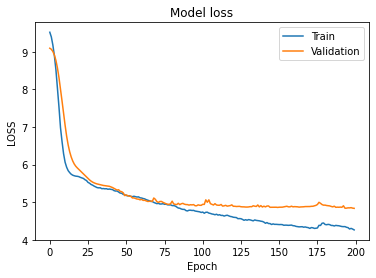

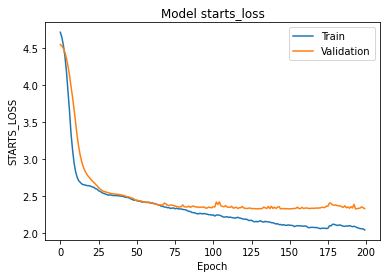

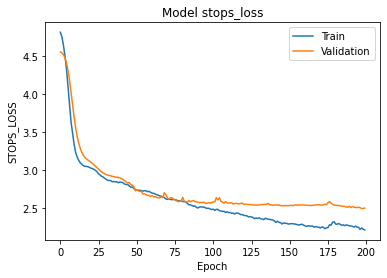

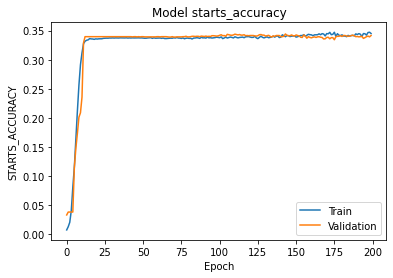

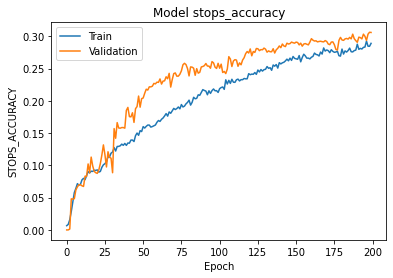

In [50]:
#metric_names = ['loss' ,'accuracy']
metric_names = ["loss", "starts_loss", "stops_loss", "starts_accuracy", "stops_accuracy"]

for i, j in zip(metric_names, ['val_'+i for i in metric_names]):
    plt.plot(history.history[i])
    plt.plot(history.history[j])
    plt.title('Model '+i)
    plt.ylabel(i.upper())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

## Validation

#### Inference

In [51]:
model.save("../results/"+MODEL_PREFIX+"EndCheckpoint.h5")

In [52]:
from tensorflow.keras.models import load_model

model = tf.keras.models.load_model(
    filepath="../results/"+MODEL_PREFIX+"BestCheckpoint.h5",
    compile=True
)

In [53]:
model.evaluate(x = {"att_flags":X_att_val, "words":X_val},
               y={"starts":Y_starts_val.argmax(axis=1), "stops":Y_stops_val.argmax(axis=1)},
               batch_size=PREDICT_BATCH_SIZE)

3013/3013 [==============================] - 2s 621us/sample - loss: 4.8341 - starts_loss: 2.3296 - stops_loss: 2.5162 - starts_accuracy: 0.3415 - stops_accuracy: 0.3060


[4.834131366186588, 2.3295732, 2.5161846, 0.34152007, 0.3060073]

In [54]:
pred_train = model.predict(x = {"att_flags":X_att_train, "words":X_train},
                           batch_size=PREDICT_BATCH_SIZE)
pred_val = model.predict(x = {"att_flags":X_att_val, "words":X_val},
                         batch_size=PREDICT_BATCH_SIZE)
pred_test = model.predict(x = {"att_flags":X_att_test, "words":X_test},
                          batch_size=PREDICT_BATCH_SIZE)

In [55]:
pred_starts_train, pred_stops_train = pred_train[0], pred_train[1]
pred_starts_val, pred_stops_val = pred_val[0], pred_val[1]
pred_starts_test, pred_stops_test = pred_test[0], pred_test[1]

In [56]:
print(pred_starts_train.shape, pred_stops_train.shape)
print(pred_starts_val.shape, pred_stops_val.shape)
print(pred_starts_test.shape, pred_stops_test.shape)

(12050, 95) (12050, 95)
(3013, 95) (3013, 95)
(2104, 95) (2104, 95)


In [57]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

In [58]:
preds = {
    "train":{
        "starts":{
            "y_true":Y_starts_train.argmax(axis=1),
            "y_pred":pred_starts_train.argmax(axis=1)
        },
        "stops":{
            "y_true":Y_stops_train.argmax(axis=1),
            "y_pred":pred_stops_train.argmax(axis=1)
        }
    },
    "valid":{
        "starts":{
            "y_true":Y_starts_val.argmax(axis=1),
            "y_pred":pred_starts_val.argmax(axis=1)
        },
        "stops":{
            "y_true":Y_stops_train.argmax(axis=1),
            "y_pred":pred_stops_train.argmax(axis=1)
        }        
    }
}

In [59]:
def print_metrics():
    funcs = [accuracy_score, f1_score, precision_score, recall_score, confusion_matrix]
    for f in funcs:
        for data_set in ["train","valid"]:
            for var in ["starts", "stops"]:
                if f in [accuracy_score]:
                    res = f(**preds[data_set][var])
                    print("{:.2f}".format(100 * res), "\t||", data_set, "\t||", var, "\t||", f.__name__)
                elif f in [confusion_matrix]:
                    res = f(**preds[data_set][var], labels = np.arange(max_len))
                    np.savetxt(X=res, fmt='%i', delimiter=",",
                               fname="../results/ConfusionMatrix_"+MODEL_PREFIX+"_"+data_set+"_"+var+".csv")
                    print("\t||", data_set, "\t||", var, "\t||", f.__name__, "\t||", 
                          "../results/ConfusionMatrix_"+MODEL_PREFIX+"_"+data_set+"_"+var+".csv")
                else:
                    res = f(**preds[data_set][var], average="macro")
                    print("{:.2f}".format(100 * res), "\t||", data_set, "\t||", var, "\t||", f.__name__)
        print("================================================================")

print_metrics()

36.30 	|| train 	|| starts 	|| accuracy_score
37.74 	|| train 	|| stops 	|| accuracy_score
34.15 	|| valid 	|| starts 	|| accuracy_score
37.74 	|| valid 	|| stops 	|| accuracy_score
7.62 	|| train 	|| starts 	|| f1_score
26.50 	|| train 	|| stops 	|| f1_score
5.77 	|| valid 	|| starts 	|| f1_score
26.50 	|| valid 	|| stops 	|| f1_score
11.51 	|| train 	|| starts 	|| precision_score
31.29 	|| train 	|| stops 	|| precision_score
7.66 	|| valid 	|| starts 	|| precision_score
31.29 	|| valid 	|| stops 	|| precision_score
8.15 	|| train 	|| starts 	|| recall_score
28.74 	|| train 	|| stops 	|| recall_score
6.28 	|| valid 	|| starts 	|| recall_score
28.74 	|| valid 	|| stops 	|| recall_score
	||

c:\users\deepak\miniconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 train 	|| starts 	|| confusion_matrix 	|| ../results/ConfusionMatrix_V12_train_starts.csv
	|| train 	|| stops 	|| confusion_matrix 	|| ../results/ConfusionMatrix_V12_train_stops.csv
	|| valid 	|| starts 	|| confusion_matrix 	|| ../results/ConfusionMatrix_V12_valid_starts.csv
	|| valid 	|| stops 	|| confusion_matrix 	|| ../results/ConfusionMatrix_V12_valid_stops.csv


#### Postprocessing

In [60]:
Y_words_train = [[vocab_itos[j] for j in i if j!=0] for num,i in enumerate(Y_train)]
Y_words_val = [[vocab_itos[j] for j in i if j!=0] for num,i in enumerate(Y_val)]

In [61]:
print(sum([s<e for s,e in zip(pred_starts_train.argmax(axis=1), pred_stops_train.argmax(axis=1))]))
print(sum([s<e for s,e in zip(pred_starts_val.argmax(axis=1), pred_stops_val.argmax(axis=1))]))
print(sum([s<e for s,e in zip(pred_starts_test.argmax(axis=1), pred_stops_test.argmax(axis=1))]))

12016
3000
2098


In [62]:
pred_words_train = [t[s:e+1] if s<e else t[e:-3] for t,s,e in zip([[vocab_itos[j] for j in i  if j!=0] for i in X_train], pred_starts_train.argmax(axis=1), pred_stops_train.argmax(axis=1))]
pred_words_val = [t[s:e+1] if s<e else t[e:-3] for t,s,e in zip([[vocab_itos[j] for j in i  if j!=0] for i in X_val], pred_starts_val.argmax(axis=1), pred_stops_val.argmax(axis=1))]
pred_words_test = [t[s:e+1] if s<e else t[e:-3] for t,s,e in zip([[vocab_itos[j] for j in i  if j!=0] for i in X_test], pred_starts_test.argmax(axis=1), pred_stops_test.argmax(axis=1))]

In [63]:
def jaccard(str1, str2):
    a = set(str1)
    b = set(str2)
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [64]:
print("Training Jaccard Score", np.mean([jaccard(str1=i, str2=j) for i,j in zip(Y_words_train, pred_words_train)]))
print("Validation Jaccard Score", np.mean([jaccard(str1=i, str2=j) for i,j in zip(Y_words_val, pred_words_val)]))

Training Jaccard Score 0.43942243974410644
Validation Jaccard Score 0.3672048522944359


In [65]:
sent_labels = {i:j for i,j in enumerate(df.sentiment_code.cat.categories)}

#### Spot Checks

In [66]:
def spot_check(index_to_check, mode):
    print("================== Sample #", index_to_check, "==================")
    if mode == "train":
        print("Selected_text:")
        print('\t', Y_words[train_idx[index_to_check]])
        print("Predicted_text:")
        print('\t', pred_words_train[index_to_check])
        print("Predictions:")
        print('\t',*[["%.2f"%j, 
                      "%.2f"%k,
                      i,
                      X_words[train_idx[index_to_check]][num]] for num, (i,j,k) in enumerate(zip(X_train[index_to_check].tolist(),
                                                                                               pred_starts_train[index_to_check].tolist(),
                                                                                               pred_stops_train[index_to_check].tolist())) if i!=0], sep="\n\t")
        
    elif mode == "validation":
        print("Selected_text:")
        print('\t', Y_words[val_idx[index_to_check]])
        print("Predicted_text:")
        print('\t', pred_words_val[index_to_check])
        print("Predictions:")
        print('\t',*[["%.2f"%j, 
                      "%.2f"%k,
                      i,
                      X_words[val_idx[index_to_check]][num]] for num, (i,j,k) in enumerate(zip(X_val[index_to_check].tolist(),
                                                                                               pred_starts_val[index_to_check].tolist(),
                                                                                               pred_stops_val[index_to_check].tolist())) if i!=0], sep="\n\t")
        
    else:
        print("Selected_text:")
        print('\t', "Not Available")
        print("Predicted_text:")
        print('\t', pred_words_test[index_to_check])
        print("Predictions:")
        print('\t',*[["%.2f"%j, 
                      "%.2f"%k,
                      i,
                      X_words_test[index_to_check][num]] for num, (i,j,k) in enumerate(zip(X_test[index_to_check].tolist(),
                                                                                               pred_starts_test[index_to_check].tolist(),
                                                                                               pred_stops_test[index_to_check].tolist())) if i!=0], sep="\n\t")

In [67]:
for i in range(10,20):
    spot_check(i, mode="train")

================== Sample # 10 ==================
Selected_text:
	 ['i', 'feel', 'like', 'i`m', 'going', 'crazy', '.']
Predicted_text:
	 ['save', 'me', '-', '-', 'i', 'feel', 'like', 'i`m', 'going', 'crazy', '.', '?']
Predictions:
	
	['0.00', '0.00', 2, 'xxxSTART']
	['0.17', '0.02', 2324, 'save']
	['0.02', '0.03', 20, 'me']
	['0.03', '0.03', 257, '-']
	['0.03', '0.03', 257, '-']
	['0.05', '0.03', 5, 'i']
	['0.07', '0.04', 387, 'feel']
	['0.11', '0.07', 65, 'like']
	['0.13', '0.08', 131, 'i`m']
	['0.14', '0.09', 159, 'going']
	['0.11', '0.15', 917, 'crazy']
	['0.07', '0.11', 21, '.']
	['0.03', '0.17', 53, '?']
	['0.01', '0.06', 109, 'http']
	['0.00', '0.04', 110, ':']
	['0.00', '0.03', 111, '/']
	['0.00', '0.01', 111, '/']
	['0.00', '0.01', 363, 'blip']
	['0.00', '0.01', 21, '.']
	['0.00', '0.00', 910, 'fm']
	['0.00', '0.00', 111, '/']
	['0.00', '0.00', 911, '~']
	['0.00', '0.00', 1, '5z193']
	['0.00', '0.00', 14, 'xxxSENTIMENT']
	['0.00', '0.00', 15, 'negative']
	['0.00', '0.00', 16, '

In [68]:
for i in range(200,210):
    spot_check(i, mode="validation")

================== Sample # 200 ==================
Selected_text:
	 ['great']
Predicted_text:
	 ['time', 'to', 'get', 'educated', 'hope', 'you', 'all']
Predictions:
	
	['0.00', '0.00', 2, 'xxxSTART']
	['0.35', '0.07', 576, 'time']
	['0.07', '0.08', 75, 'to']
	['0.11', '0.09', 284, 'get']
	['0.12', '0.11', 5584, 'educated']
	['0.11', '0.11', 168, 'hope']
	['0.09', '0.11', 8, 'you']
	['0.07', '0.13', 48, 'all']
	['0.04', '0.09', 44, 'are']
	['0.03', '0.06', 529, 'off']
	['0.01', '0.05', 42, 'for']
	['0.00', '0.02', 104, 'a']
	['0.00', '0.02', 528, 'great']
	['0.00', '0.01', 894, 'start']
	['0.00', '0.01', 35, 'on']
	['0.00', '0.01', 536, 'this']
	['0.00', '0.01', 418, 'monday']
	['0.00', '0.00', 480, 'morning']
	['0.00', '0.00', 14, 'xxxSENTIMENT']
	['0.00', '0.00', 51, 'positive']
	['0.00', '0.00', 16, 'xxxEND']
================== Sample # 201 ==================
Selected_text:
	 ['you', 'are', 'pretty', 'man', '.', '.']
Predicted_text:
	 ['http', ':', '/', '/', 'tinyurl', '.', 'com', '/

In [69]:
for i in range(10,20):
    spot_check(i, mode="test")

================== Sample # 10 ==================
Selected_text:
	 Not Available
Predicted_text:
	 ['so', 'hot', 'today', '=', '_', '=', 'don`t', 'like', 'it', 'and', 'i', 'hate', 'my', 'new', 'xxxUNK', ',', 'having', 'such', 'a', 'bad', 'week']
Predictions:
	
	['0.00', '0.00', 2, 'xxxSTART']
	['0.12', '0.01', 271, 'so']
	['0.01', '0.01', 1991, 'hot']
	['0.01', '0.01', 193, 'today']
	['0.01', '0.00', 420, '=']
	['0.00', '0.00', 251, '_']
	['0.01', '0.00', 420, '=']
	['0.01', '0.00', 260, 'don`t']
	['0.01', '0.00', 65, 'like']
	['0.01', '0.00', 106, 'it']
	['0.02', '0.00', 50, 'and']
	['0.03', '0.00', 5, 'i']
	['0.04', '0.01', 468, 'hate']
	['0.06', '0.02', 17, 'my']
	['0.09', '0.03', 118, 'new']
	['0.09', '0.03', 1, 'timetable']
	['0.10', '0.04', 29, ',']
	['0.10', '0.06', 646, 'having']
	['0.10', '0.12', 610, 'such']
	['0.07', '0.12', 104, 'a']
	['0.05', '0.12', 510, 'bad']
	['0.03', '0.16', 339, 'week']
	['0.01', '0.14', 14, 'xxxSENTIMENT']
	['0.01', '0.06', 15, 'negative']
	['0.00',